In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import cv2
import time
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import  (Input, Dense, Dropout,Flatten, Conv2D, GlobalAveragePooling2D,MaxPooling2D, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-05-04 11:08:44.244404: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-04 11:08:44.351696: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 11:08:46.088934: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def dataset_generator(path):
    data={'img_path':[],'labels':[]}
    folders=os.listdir(path)
    
    for folder in folders:
        folderpath = os.path.join(path,folder)
        files = os.listdir(folderpath)
        
        for file in files:
            filepath = os.path.join(folderpath,file)
            data['img_path'].append(filepath)
            data['labels'].append(folder)
            
    return pd.DataFrame(data)

def dataset_splitter(dataset, train_size = 0.9, shuffle = True, random_state = 0):
    train_df, val_df = train_test_split(dataset, train_size = train_size, shuffle = shuffle, random_state = random_state)

    train_df = train_df.reset_index(drop = True)
    val_df = val_df.reset_index(drop = True)
    
    return train_df, val_df


def plot_counts(dataset):
    species_counts = dataset['labels'].value_counts()

    plt.figure(figsize=(12, 6))
    species_counts.plot(kind = 'bar', color = 'skyblue')
    plt.title("Count of Alphabets")
    plt.xlabel("Alphabets")
    plt.ylabel("Count")
    plt.xticks(rotation = 45, ha = 'right')
    plt.tight_layout()
    plt.show()

In [4]:
dataset_path = "/home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Sign-Language-Detection/DATA/asl_alphabet_train/asl_alphabet_train"
dataset = dataset_generator(dataset_path)

dataset

,img_path,labels
0,/home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...,Q
1,/home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...,Q
2,/home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...,Q
3,/home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...,Q
4,/home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...,Q
...,...,...
86995,/home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...,del
86996,/home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...,del
86997,/home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...,del
86998,/home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...,del


In [ ]:
plt.show()

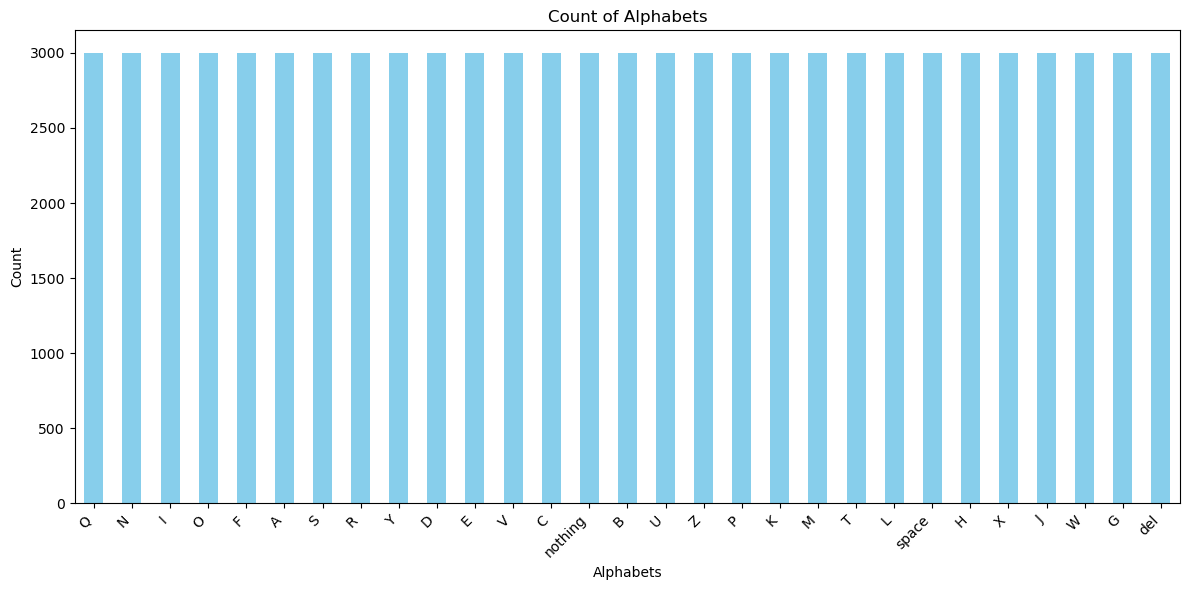

In [5]:
plot_counts(dataset)

In [6]:
train_df, val_df= dataset_splitter(dataset)

print(f'\nTraining Dataframe of shape {train_df.shape}: \n{train_df.head()}')
print(f'\nValidation Dataframe of shape {val_df.shape}: \n{val_df.head()}')


Training Dataframe of shape (78300, 2): 
                                            img_path labels
0  /home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...      C
1  /home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...      H
2  /home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...      I
3  /home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...      B
4  /home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...      S

Validation Dataframe of shape (8700, 2): 
                                            img_path labels
0  /home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...      J
1  /home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...      A
2  /home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...      Z
3  /home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...      V
4  /home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...      B


In [7]:
BATCH_SIZE=128
IMG_SIZE = (64,64)

train_generator = ImageDataGenerator(1./255,rotation_range=10,height_shift_range=0.1,width_shift_range=0.1)
val_generator = ImageDataGenerator(1./255)

train_images = train_generator.flow_from_dataframe(train_df, x_col = 'img_path', y_col = 'labels',color_mode = 'grayscale', class_mode = 'categorical',batch_size = BATCH_SIZE, target_size = IMG_SIZE,shuffle = True, seed = 0)

val_images = val_generator.flow_from_dataframe(val_df, x_col = 'img_path', y_col = 'labels',color_mode = 'grayscale', class_mode = 'categorical',batch_size = BATCH_SIZE, target_size = IMG_SIZE)

Found 78300 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.
